In [2]:
import json
import re
import pandas as pd
import urllib
from tqdm import tqdm
from urllib.request import Request
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
url = 'https://www.otodom.pl/pl/oferty/sprzedaz/mieszkanie/krakow?distanceRadius=0&locations=%5Bcities_6-38%5D&viewType=listing&page='

apartaments = []
for page_number in tqdm(range(1,300)):
    with urllib.request.urlopen(f'{url}{page_number}') as resp:
        page = BeautifulSoup(resp.read().decode('utf-8'), "html.parser")
        apartaments_html = page.find_all(attrs={'data-cy': 'listing-item'})
        
        for apartament_html in apartaments_html:
          apart_dto = {}
          apart_dto['name'] = apartament_html.find(attrs={'data-cy': 'listing-item-title'}).text
          more_info = apartament_html.find('div', 'e1n6ljqa19').select('span')
          if len(more_info) != 4:
            raise ValueError('exception to 4 additional info blocks')
          

          for info in more_info:
            info_type = info.findAll('strong')
            if len(info_type) > 0:
              # try:
              data = re.sub(r'[\s]+', '', re.sub(r'(€|zł)\/m²', '', info.text))
              apart_dto['price_per_m2'] = float(data)
              # except ValueError:
              #   apart_dto['price_per_m2'] = None
              continue
            info_strings = re.sub('\xa0', ' ', info.text).split(' ')
            if info_strings[-1] == 'zł':
              # try:
              data = re.sub(r'[\s]+', '', re.sub(r'(€|zł)', '', info.text.replace(',', '.')))
              apart_dto['price'] = float(data)
              data = re.sub(r'[\s]+', '', re.sub(r'\d+.\d+', '', info.text))
              apart_dto['currency'] = data
              # except ValueError:
              #   apart_dto['price'] = None
            elif info_strings[-1] == 'm²':
              try:
                data = re.sub(r'[\s]+', '', info.text.replace('m²', ''))
                apart_dto['area'] = float(info.text.replace(' ', '').replace('m²', ''))
              except ValueError:
                apart_dto['area'] = None
            elif re.match(r'pok', info_strings[-1]):
              try:
                apart_dto['rooms'] = int(info_strings[0])
              except ValueError:
                apart_dto['rooms'] = None

          apartaments.append(apart_dto)

 14%|█▍        | 42/299 [00:32<03:17,  1.30it/s]


ValueError: could not convert string to float: '377539,50'

In [10]:
df = pd.DataFrame.from_dict(apartaments)
df.head(5)

,name,price,currency,price_per_m2,rooms,area
0,Luksusowy apartament z garażem Stare Miasto Kr...,963641.0,zł,32900.0,1,29.29
1,Ustawna kawalerka | Ruczaj | inwestycja| NOWA ...,199000.0,zł,10102.0,1,19.70
2,3-pokojowe | Po generalnym remoncie | Z widokiem…,598000.0,zł,12888.0,3,46.40
3,Trzypokojowe po remoncie przy parku,597000.0,zł,12756.0,3,46.80
4,"Gotowe 2-Pokojowe, Słoneczne Mieszkanie",449000.0,zł,9071.0,2,49.50


In [20]:
df[df['price_per_m2'].isna()].head(20)

,name,price,currency,price_per_m2,rooms,area
21,2-pokojowe mieszkanie 53m2 + balkon,NaN,NaN,NaN,2,53.14
27,2-pokojowe mieszkanie 41m2 + ogródek,NaN,NaN,NaN,2,41.99
29,2-pokojowe mieszkanie 34m2 + ogródek,NaN,NaN,NaN,2,34.52
106,4-pokojowe mieszkanie 111m2 + balkon Bez Prowizji,NaN,NaN,NaN,4,111.52
107,4-pokojowe mieszkanie 112m2 + balkon Bez Prowizji,NaN,NaN,NaN,4,112.32
112,3-pokojowe mieszkanie 71m2 + balkon Bezpośrednio,NaN,NaN,NaN,3,71.88
118,Młyny Mogilska | przestronne mieszkanie M149,NaN,NaN,NaN,3,48.88
153,Apartament Kościuszki 47 - M49 REZERWACJA,NaN,NaN,NaN,1,38.49
171,Emaus Garden | apartament B5-A20,NaN,NaN,NaN,3,58.42
173,Emaus Garden | apartament B1-A3,NaN,NaN,NaN,3,62.03


(0.0, 40000.0)

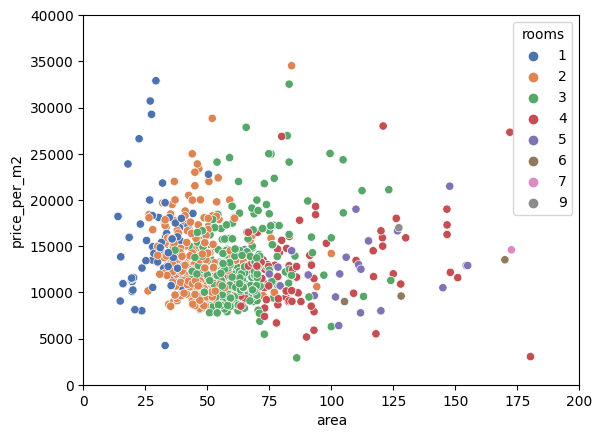

In [12]:
sns.scatterplot(x='area', y='price_per_m2', data=df.dropna(subset=['price']), hue='rooms', palette="deep")
plt.xlim((0, 200))
plt.ylim((0, 40_000))

<AxesSubplot: xlabel='rooms', ylabel='count'>

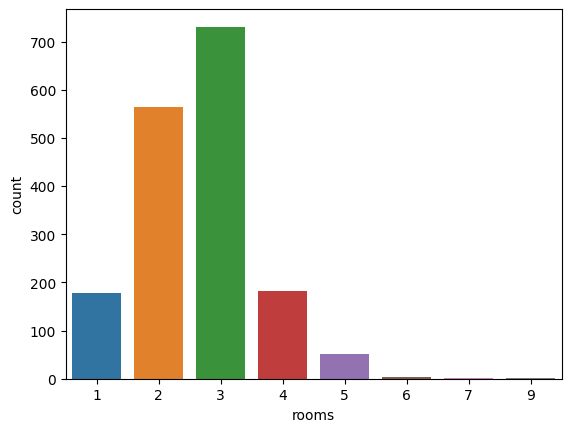

In [11]:
sns.countplot(x=df["rooms"])

(0.0, 30000.0)

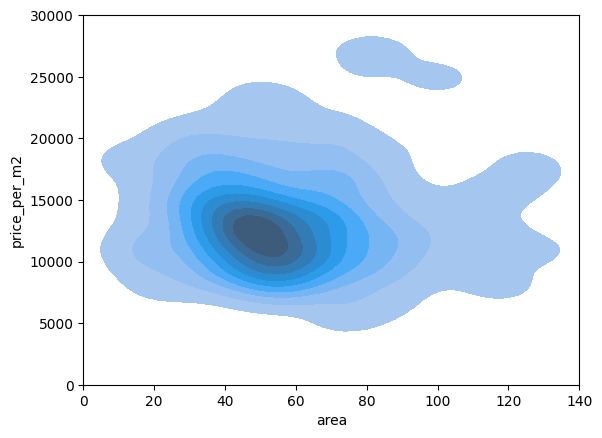

In [19]:
sns.kdeplot(x='area', y='price_per_m2', data=df.dropna(subset=['price']), fill=True)
plt.xlim((0, 140))
plt.ylim((0, 30_000))